In [1]:
# The code was removed by Watson Studio for sharing.

In [22]:
import pandas as pd
import numpy as np

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb

from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

import types
from ibm_botocore.client import Config
import ibm_boto3

import warnings
import types
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# The code was removed by Watson Studio for sharing.

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,YearBuilt,...,Heating_OthW.1,Heating_Wall.1,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,1,60,65.0,8450,1,1,0,7,5,2003,...,0,0,0,0,0,1,1,0,0,0
1,2,20,80.0,9600,1,1,0,6,8,1976,...,0,0,0,0,0,1,1,0,0,0
2,3,60,68.0,11250,1,1,0,7,5,2001,...,0,0,0,0,0,1,1,0,0,0
3,4,70,60.0,9550,1,1,0,7,5,1915,...,0,0,0,0,0,1,1,0,0,0
4,5,60,84.0,14260,1,1,0,8,5,2000,...,0,0,0,0,0,1,1,0,0,0


# Linear Regression

In [4]:
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)
print('y_train : ', y_train.shape)
print('y_test : ', y_test.shape)

X_train :  (1020, 229)
X_test :  (438, 229)
y_train :  (1020,)
y_test :  (438,)


In [7]:
sc = StandardScaler()

In [8]:
sc.fit_transform(X_train)

array([[-0.86824345, -0.48720324, -0.20627038, ..., -0.04432422,
        -0.20979104,  0.        ],
       [-0.13894755, -0.8634825 , -0.42118407, ..., -0.04432422,
        -0.20979104,  0.        ],
       [ 0.46879903, -0.8634825 ,  0.13307735, ..., -0.04432422,
        -0.20979104,  0.        ],
       ..., 
       [-0.86824345,  0.07721564, -0.18566222, ..., -0.04432422,
        -0.20979104,  0.        ],
       [-0.86824345,  0.03018073,  0.079398  , ..., -0.04432422,
        -0.20979104,  0.        ],
       [ 2.5351374 , -0.41665088, -0.53678605, ..., -0.04432422,
        -0.20979104,  0.        ]])

In [9]:
sc.fit_transform(X_test)

array([[ 2.90852057,  1.40985582,  2.69826127, ...,  0.        ,
        -0.11785113, -0.04783649],
       [-0.88427175,  0.63367937,  0.01414651, ...,  0.        ,
        -0.11785113, -0.04783649],
       [ 0.67746626,  0.17710499, -0.19367021, ...,  0.        ,
        -0.11785113, -0.04783649],
       ..., 
       [ 0.00814997,  0.22276243, -0.27121377, ...,  0.        ,
        -0.11785113, -0.04783649],
       [ 0.2312554 , -0.18815451,  0.15594044, ...,  0.        ,
        -0.11785113, -0.04783649],
       [-0.88427175, -0.18815451, -0.24008557, ...,  0.        ,
        -0.11785113, -0.04783649]])

In [10]:
# Error measure for RMSE scoring.
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [11]:
def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

In [12]:
def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

In [13]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

In [18]:
lm.score(X_test, y_test)

0.90437602777772597

RMSE on Training set : 0.126013606296
RMSE on Test set : 0.126013606296


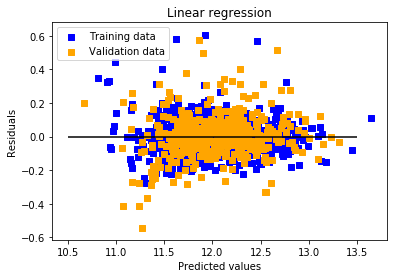

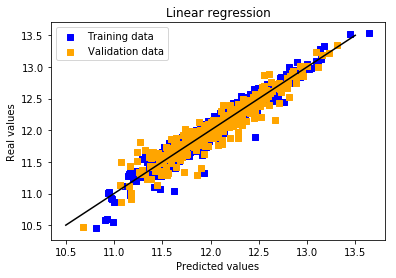

In [16]:
# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lm).mean())
print("RMSE on Test set :", rmse_cv_test(lm).mean())
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Random Forest

In [37]:
rfr = RandomForestRegressor(bootstrap=True, 
                            n_estimators=100, 
                            n_jobs=1, 
                            random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [38]:
rfr.score(X_test, y_test)

0.89390265219786813

Random Forest RMSE on Training set : 0.144516642864
Random Forest RMSE on Test set : 0.144516642864


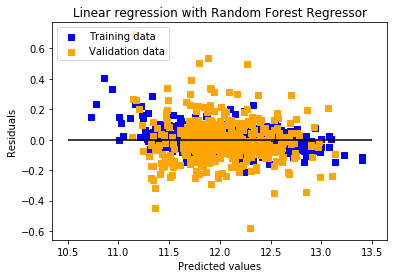

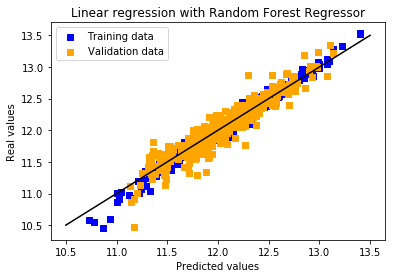

In [39]:
print("Random Forest RMSE on Training set :", rmse_cv_train(rfr).mean())
print("Random Forest RMSE on Test set :", rmse_cv_test(rfr).mean())
y_train_rfr = rfr.predict(X_train)
y_test_rfr = rfr.predict(X_test)

# Plot residuals
plt.scatter(y_train_rfr, y_train_rfr - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rfr, y_test_rfr - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Random Forest Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_rfr, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rfr, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Random Forest Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Lasso

In [24]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=1))
lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [25]:
lasso.score(X_test, y_test)

0.92501299820153871

Lasso RMSE on Training set : 0.117189831199
Lasso RMSE on Test set : 0.117189831199


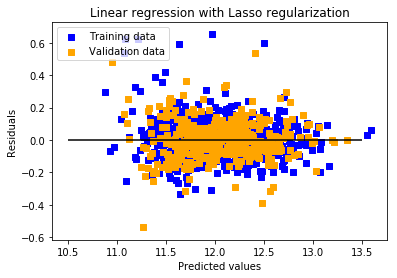

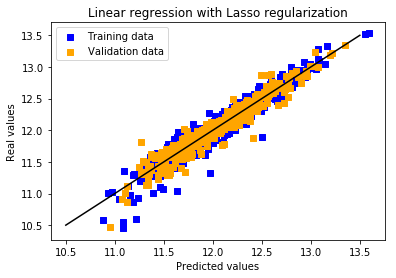

In [27]:
print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()